### Customer_clustering

참고 : https://www.kaggle.com/code/chloe1701/customer-clustering#DBScan-Clustering%C2%B6

In [2]:
import warnings 
warnings.filterwarnings('ignore')
import os

import pandas as pd 
import numpy as np 
import math

import matplotlib.pyplot as plt 
import seaborn as sns
from plotly.subplots import make_subplots 
import plotly.express as px
import plotly.graph_objects as go 
import matplotlib.cm as cm

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

from scipy import stats
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA 

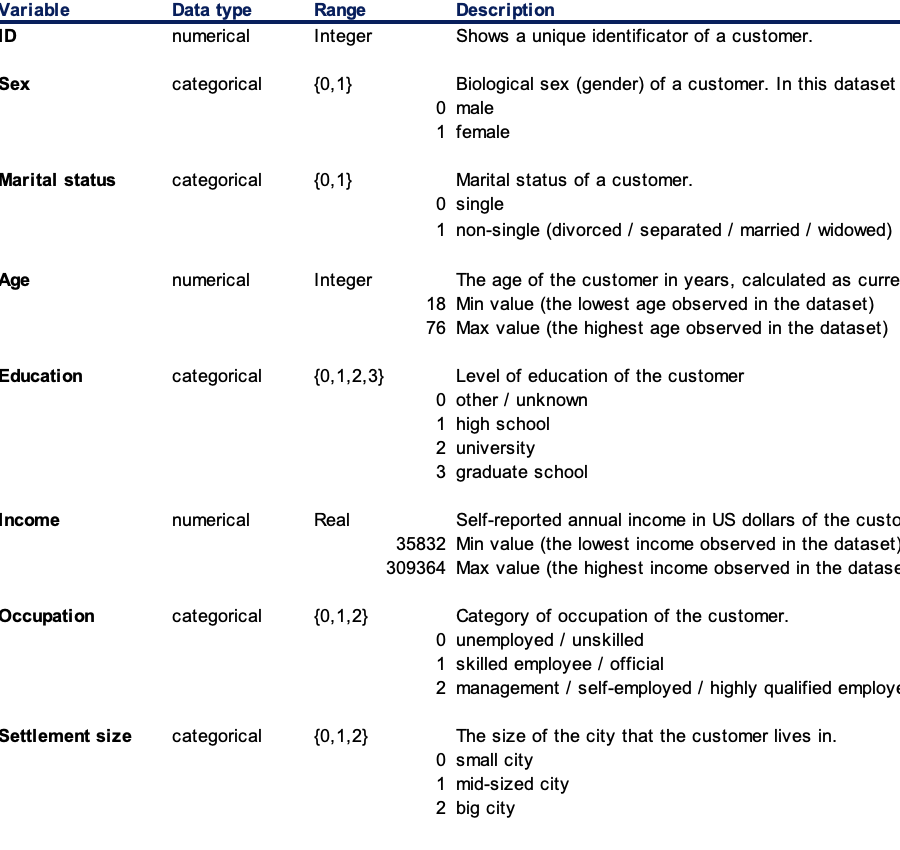

In [3]:
cust_file = '/Users/gwagseongchan/Desktop/Exercise/python/ML/customer_clustering/segmentation data.csv'
cust_df = pd.read_csv(cust_file)

In [4]:
# cust_df.keys()

# ID 겹치는 것이 없음을 확인 후 제거
sum(cust_df['ID'].duplicated())
cust_df.drop(['ID'], inplace=True, axis=1)

In [5]:
cust_df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,67,2,124670,1,2
1,1,1,22,1,150773,1,2
2,0,0,49,1,89210,0,0
3,0,0,45,1,171565,1,1
4,0,0,53,1,149031,1,1


In [6]:
def create_temp_df(temp_df):
    """
    Match values to origin meanings
    Args:
        temp_df (DataFrame)

    Returns:
        temp_df (dataFrame)
    """
    temp_df = temp_df.copy() 
    temp_df['Sex'] = temp_df['Sex'].replace(0, 'Male')
    temp_df['Sex'] = temp_df['Sex'].replace(1, 'Female')
    temp_df['Marital status'] = temp_df['Marital status'].replace(0, 'Single')
    temp_df['Marital status'] = temp_df['Marital status'].replace(1, 'Non-Single')
    temp_df['Education'] = temp_df['Education'].replace(0, 'Other/Unknown')
    temp_df['Education'] = temp_df['Education'].replace(1, 'High School')
    temp_df['Education'] = temp_df['Education'].replace(2, 'University')
    temp_df['Education'] = temp_df['Education'].replace(3, 'Graduate School')
    temp_df['Occupation'] = temp_df['Occupation'].replace(0, 'Unskilled Employee')
    temp_df['Occupation'] = temp_df['Occupation'].replace(1, 'Skilled Employee')
    temp_df['Occupation'] = temp_df['Occupation'].replace(2, 'Highly Qualified Employee')
    temp_df['Settlement size'] = temp_df['Settlement size'].replace(0, 'Small City')
    temp_df['Settlement size'] = temp_df['Settlement size'].replace(1, 'Mid-Sized City')
    temp_df['Settlement size'] = temp_df['Settlement size'].replace(2, 'Big City')
    return temp_df

In [7]:
temp_df = create_temp_df(cust_df)
temp_df

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,Male,Single,67,University,124670,Skilled Employee,Big City
1,Female,Non-Single,22,High School,150773,Skilled Employee,Big City
2,Male,Single,49,High School,89210,Unskilled Employee,Small City
3,Male,Single,45,High School,171565,Skilled Employee,Mid-Sized City
4,Male,Single,53,High School,149031,Skilled Employee,Mid-Sized City
...,...,...,...,...,...,...,...
1995,Female,Single,47,High School,123525,Unskilled Employee,Small City
1996,Female,Non-Single,27,High School,117744,Skilled Employee,Small City
1997,Male,Single,31,Other/Unknown,86400,Unskilled Employee,Small City
1998,Female,Non-Single,24,High School,97968,Unskilled Employee,Small City


In [8]:
temp_df.isnull().sum()

Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

In [9]:
row_n = 3   # 3행
col_n = 2   # 2열


sex_counts, marital_counts, education_counts, occupation_counts, settlement_counts = [
    temp_df[col].value_counts().sort_values(ascending=True) 
    for col in ['Sex', 'Marital status', 'Education', 'Occupation', 'Settlement size']
]
categorical_lst = [sex_counts, marital_counts, education_counts, occupation_counts, settlement_counts]
categorical_labels = ['Sex', 'Marital Status', 'Education', 'Occupation', 'Settlement Size']

fig = make_subplots(rows=row_n, cols=col_n)

for i, col in enumerate(categorical_labels):
    # add_trace() : 이미 있는 FIgure에 새로운 Trace 추가
    #e) go.Bar, go.Scatter
    # update_trace(업데이트 내용) : 이미 생성된 trace의 type, 색, 스타일, 템플릿 편집
    '''
    e) fig.update_traces(marker=dict(color="RoyalBlue"),
                  selector=dict(type="bar"))
    '''
    # update_layout(업데이트 내용) : 그래프 사이즈, 제목, 글꼴크기 등 세팅
    '''
    e) fig.update_layout(title_text="Using update_layout() With Graph Object Figures",title_font_size=30)
    '''
    fig.add_trace(
        go.Bar(
            x = categorical_lst[i].index.astype('str'), # index를 str으로 변환
            y = categorical_lst[i].values,
            name = col,
            text = np.round(categorical_lst[i].values, 3),   # 각 막대에 값 표시
            textposition = 'inside',
            marker_color = px.colors.sequential.Emrld, 
            textfont = dict(size=10)
        ),
        row = int(i/col_n) + 1, col = int(i%col_n) + 1          # 행 : idx/열 길이 + 1, 열 : (idx / col_n의 몫) + 1
    )
fig.update_layout(
    height = 1000,  # 그래프 전체 높이 1000px
    title_text = "Categorical Variable Distribution",
    template = "simple_white"   # 배경색 제거
    )
fig.update_traces(
    marker_line_color = 'black',    # 막대 테두리 색상 : 검정
    marker_line_width = 1.5,    # 막대 테두리 두께 : 1.5
    opacity = 0.8   # 투명도 : 0.8
)
       
fig.show()

### EDA

In [10]:
gender_by_marital = pd.DataFrame(cust_df.groupby('Sex')['Marital status'].value_counts())         # 성별 결혼 유무의 갯수 반환
print(gender_by_marital)
gender_by_marital.iloc[0]

                    count
Sex Marital status       
0   0                 829
    1                 257
1   1                 736
    0                 178


count    829
Name: (0, 0), dtype: int64

In [11]:
marital_colors=['darkgreen', '#ACDF87']

gender_by_marital = pd.DataFrame(cust_df.groupby('Sex')['Marital status'].value_counts())         # 성별 결혼 유무의 갯수 반환
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])     # specs:서브플롯의 유형 지정,type:domain - 파이,도넛차트

# Male
fig.add_trace(go.Pie(labels=['Single', 'Non-Single'], 
                     values=[int(gender_by_marital.loc[0,0]), int(gender_by_marital.loc[0,1])],          # loc : 라벨 기반, iloc : 정수 인덱스기반 e.iloc[0,1] = 0행 1열 선택
                     textinfo='percent+value+label',
                     marker_colors=marital_colors,
                     name="Male"),
              row = 1, col = 1)

# Femal
fig.add_trace(go.Pie(labels=['Single', 'Non-Single'], 
                     values=[int(gender_by_marital.loc[1,0]), int(gender_by_marital.loc[1,1])], 
                     textinfo='percent+value+label',
                     marker_colors=marital_colors,
                     name="Female"),
              row = 1, col = 2)

fig.update_traces(hole=.3, hoverinfo="label+percent+name",
                  marker_line_color='black', 
                  marker_line_width=1.5, 
                  opacity=0.8)
fig.update_layout(
    title_text="Gender and Marital Status Distribution",
    annotations=[dict(text='Male', x=0.195, y=0.5, font_size=20, showarrow=False),
                 dict(text='Female', x=0.825, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [12]:
cust_df.keys()

Index(['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation',
       'Settlement size'],
      dtype='object')

In [13]:
# gender by education
education_colors = ['#ACDF87', 'darkgreen', 'seagreen', '#68BB59']
gender_by_education = pd.DataFrame(cust_df.groupby('Sex')['Education'].value_counts())

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}]])

# 반복문으로 Male과 Female의 파이 차트 추가
for idx, gender in enumerate(['Male', 'Female']):
    fig.add_trace(
        go.Pie(
            labels=['Other/Unknown', 'High School', 'University', 'Graduate School'],
            values=[
                int(gender_by_education.loc[idx, 0]),
                int(gender_by_education.loc[idx, 1]),
                int(gender_by_education.loc[idx, 2]),
                int(gender_by_education.loc[idx, 3])
            ],
            textinfo='percent+value+label',
            marker_colors=education_colors,
            name=gender
        ),
        row=1, col=idx + 1  # idx가 0이면 1열, 1이면 2열
    )

fig.update_traces(hole=.3, hoverinfo="label+percent+name",
                  marker_line_color='black', 
                  marker_line_width=1.5, 
                  opacity=0.8)
fig.update_layout(
    title_text="Gender and Education Distribution",
    annotations=[
        dict(text='Male', x=0.195, y=0.5, font_size=20, showarrow=False),
        dict(text='Female', x=0.825, y=0.5, font_size=20, showarrow=False)
    ]
)
fig.show()

In [14]:
fig = px.histogram(temp_df, x='Sex', y='Age',
                 color='Marital status', barmode='group',
                 histfunc='avg', text_auto=True,
                 template='simple_white',
                 title='Gender, Age, and Marital Status Distribution',
                 color_discrete_sequence=['darkgreen', '#ACDF87'])

fig.update_traces(marker_line_color='black', 
                  marker_line_width=1.5, 
                  opacity=0.8)
fig.show()

In [15]:
income_by_sex = temp_df.groupby('Sex')['Income'].mean().sort_values(ascending=True)
income_by_marital = temp_df.groupby('Marital status')['Income'].mean().sort_values(ascending=True)
income_by_age = temp_df.groupby('Age')['Income'].mean()
income_by_education = temp_df.groupby('Education')['Income'].mean().sort_values(ascending=True)
income_by_occupation = temp_df.groupby('Occupation')['Income'].mean().sort_values(ascending=True)
income_by_settlement = temp_df.groupby('Settlement size')['Income'].mean().sort_values(ascending=True)
income_lst = [income_by_sex, income_by_marital, income_by_age, income_by_education, income_by_occupation, income_by_settlement]
income_labels = ['Sex', 'Marital Status', 'Age', 'Education', 'Occupation', 'Settlement Size']

row_n = 3
col_n = 2 

fig = make_subplots(rows=row_n, cols=col_n)

for i, col in enumerate(income_labels):
    fig.add_trace(
        go.Bar(
            x=income_lst[i].index.astype('str'),
            y=income_lst[i].values, 
            name=col,
            text=np.round(income_lst[i].values,3),
            textposition='inside',
            marker_color=px.colors.sequential.Emrld,
            textfont=dict(size=10)),
        row=int(i/col_n)+1, col=int(i%col_n)+1
        )

fig.update_layout(
    height=800,
    title_text="Bar Chart on Income Analysis", 
    template='simple_white')
fig.update_traces(marker_line_color='black', 
                  marker_line_width=1.5, 
                  opacity=0.8)
fig.show()


### Standardizing the Data

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cust_df_scaled = pd.DataFrame(scaler.fit_transform(cust_df), columns=scaler.get_feature_names_out())
cust_df_scaled

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,-0.917399,-0.993024,2.653614,1.604323,0.097524,0.296823,1.552326
1,1.090038,1.007025,-1.187132,-0.063372,0.782654,0.296823,1.552326
2,-0.917399,-0.993024,1.117316,-0.063372,-0.833202,-1.269525,-0.909730
3,-0.917399,-0.993024,0.775916,-0.063372,1.328386,0.296823,0.321298
4,-0.917399,-0.993024,1.458716,-0.063372,0.736932,0.296823,0.321298
...,...,...,...,...,...,...,...
1995,1.090038,-0.993024,0.946616,-0.063372,0.067471,-1.269525,-0.909730
1996,1.090038,1.007025,-0.760382,-0.063372,-0.084265,0.296823,-0.909730
1997,-0.917399,-0.993024,-0.418983,-1.731068,-0.906957,-1.269525,-0.909730
1998,1.090038,1.007025,-1.016432,-0.063372,-0.603329,-1.269525,-0.909730


### PCA

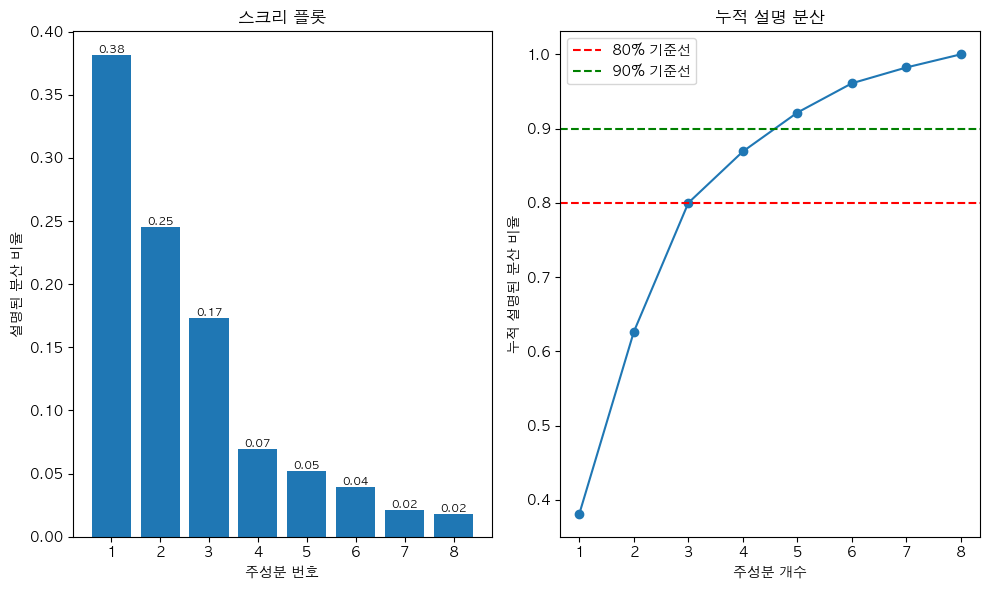

80%의 분산을 설명하는 주성분 개수: 4
90%의 분산을 설명하는 주성분 개수: 5

설명된 분산 비율 (각 주성분):
주성분 1: 0.3812 (0.3812 누적)
주성분 2: 0.2452 (0.6264 누적)
주성분 3: 0.1735 (0.8000 누적)
주성분 4: 0.0692 (0.8691 누적)
주성분 5: 0.0524 (0.9215 누적)
주성분 6: 0.0394 (0.9610 누적)
주성분 7: 0.0213 (0.9823 누적)
주성분 8: 0.0177 (1.0000 누적)


In [38]:
from matplotlib import rc
rc('font', family='AppleGothic')  # MacOS의 경우
# rc('font', family='Malgun Gothic')  # Windows의 경우
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지


# PCA 모델 생성 (모든 성분 유지)
pca = PCA()
pca.fit(cust_df_scaled)

# 설명된 분산 비율 계산
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 주성분 개수 결정을 위한 시각화
plt.figure(figsize=(10, 6))

# 스크리 플롯 (각 주성분별 설명 분산)
plt.subplot(1, 2, 1)
bars = plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('주성분 번호')
plt.ylabel('설명된 분산 비율')
plt.title('스크리 플롯')
plt.xticks(range(1, len(explained_variance_ratio) + 1))

# 각 막대 위에 설명된 분산 비율 값 표시
for bar, ratio in zip(bars, explained_variance_ratio):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{ratio:.2f}', 
             ha='center', va='bottom', fontsize=8)

# 누적 분산 플롯
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% 기준선')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% 기준선')
plt.xlabel('주성분 개수')
plt.ylabel('누적 설명된 분산 비율')
plt.title('누적 설명 분산')
plt.xticks(range(1, len(cumulative_variance_ratio) + 1))
plt.legend()

plt.tight_layout()
plt.show()

# 누적 분산 80%와 90%를 설명하는 주성분 개수 찾기
n_components_80 = np.argmax(cumulative_variance_ratio >= 0.8) + 1
n_components_90 = np.argmax(cumulative_variance_ratio >= 0.9) + 1

print(f"80%의 분산을 설명하는 주성분 개수: {n_components_80}")
print(f"90%의 분산을 설명하는 주성분 개수: {n_components_90}")
print("\n설명된 분산 비율 (각 주성분):")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"주성분 {i+1}: {ratio:.4f} ({cumulative_variance_ratio[i]:.4f} 누적)")
    # 한글 인코딩 문제 해결을 위해 폰트 설정
    


In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=42)      # 전체 데이터의 80%를 설명하는 3개의 축을 선택.
reduced_df = pca.fit_transform(cust_df_scaled)
reduced_df

array([[ 2.58824057,  0.88984484,  2.29553586],
       [-0.31863774,  1.34940665, -2.08552617],
       [-0.21185785, -1.21490339,  1.96535146],
       ...,
       [-0.67207582, -2.58413882,  0.26592331],
       [-2.25358176, -0.20559311, -0.1432446 ],
       [-1.01858521, -2.87752241,  0.00880173]])

### Clustering Modelling

In [34]:
model = KMeans(n_clusters=3, random_state = 42)
labels = model.fit_predict(reduced_df)
print(labels)
centroids = model.cluster_centers_

[0 1 2 ... 2 2 2]


In [35]:
cust_df_scaled['Cluster'] = labels
cust_df_scaled['Cluster'].value_counts()

Cluster
1    699
2    658
0    643
Name: count, dtype: int64

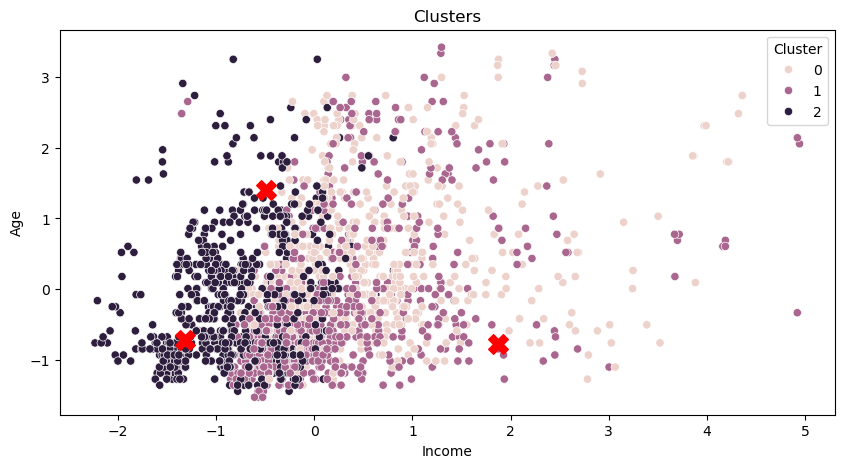

In [36]:
plt.figure(figsize=(10,5))
sns.scatterplot(cust_df_scaled, x='Income', y='Age', hue='Cluster')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('Clusters')
plt.show()

In [40]:
inertia_values = []
for k in range(1, 21):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(cust_df_scaled)
    inertia_values.append(model.inertia_)

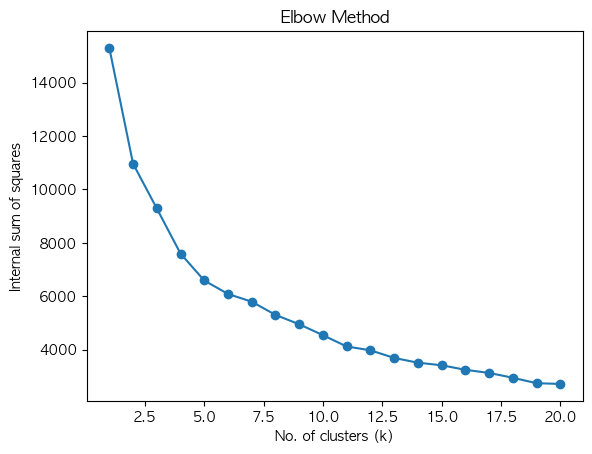

In [41]:
plt.plot(range(1,21), inertia_values, marker='o')
plt.title('Elbow Method')
plt.xlabel('No. of clusters (k)')
plt.ylabel('Internal sum of squares')
plt.show()

In [42]:
s_score = silhouette_score(reduced_df, labels)
db_score = davies_bouldin_score(reduced_df, labels)
print(f"Silhouette score: {s_score}")
print(f"Davies bouldin score: {db_score}")

Silhouette score: 0.36459433122514723
Davies bouldin score: 1.0675059890353804
